# Utility Validation: Comparing Model Performance on Original vs Anonymized Data

This notebook evaluates the utility of anonymized data by comparing machine learning model performance on:
1. **Original Data** - Raw customer data
2. **Anonymized Data** - Data processed with anonymization techniques

We'll predict **income** from **age** and **zip code** using various models, then compare metrics and visualize the results.


## 1. Setup and Data Loading


In [101]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Import anonymization modules
import sys
sys.path.append('..')
from src.anonymizer import Anonymizer
from src.config_loader import load_config
from src.utility_metrics import compare_utility

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [102]:
# Load customer data
df = pd.read_csv('../fixtures/customers.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (2000, 10)

Columns: ['name', 'email', 'phone', 'ssn', 'address', 'city', 'state', 'zip', 'dob', 'income']

First few rows:


,name,email,phone,ssn,address,city,state,zip,dob,income
0,Allison Hill,donaldgarcia@example.net,+1-219-560-0133,734-84-8929,79402 Peterson Drives Apt. 511,Chicago,IL,60601,1992-01-01,60000
1,Ian Cooper,lindsay78@example.org,(518)349-5931x0341,390-36-7429,55341 Amanda Gardens Apt. 764,Chicago,IL,60601,1977-01-01,75000
2,Margaret Hawkins DDS,perezantonio@example.com,(541)639-5376x7242,765-75-7020,3287 Katelyn Wall Apt. 226,New York,NY,10001,1993-12-01,75000
3,Janice Carlson,jrice@example.org,+1-318-645-1462x70482,862-82-8318,52880 Burns Creek,Los Angeles,CA,90001,1977-06-01,60000
4,Sherry Decker,john39@example.org,671-882-2782,217-70-3296,5787 John Circles Suite 098,Los Angeles,CA,90001,1985-01-01,90000


In [103]:
# Calculate age from date of birth
df['dob'] = pd.to_datetime(df['dob'])
current_year = datetime.now().year
df['age'] = current_year - df['dob'].dt.year

# Extract first 3 digits of zip code for generalization
df['zip'] = df['zip'].astype(str).str.zfill(5)  # Ensure 5 digits
df['zip_prefix'] = df['zip'].str[:3].astype(int)

# Select features for modeling
print("Feature Engineering:")
print(f"  ✓ Calculated age from DOB")
print(f"  ✓ Extracted zip code prefix (first 3 digits)")
print(f"\nAge range: {df['age'].min()} - {df['age'].max()}")
print(f"Income range: ${df['income'].min():,} - ${df['income'].max():,}")
print(f"Unique zip prefixes: {df['zip_prefix'].nunique()}")


Feature Engineering:
  ✓ Calculated age from DOB
  ✓ Extracted zip code prefix (first 3 digits)

Age range: 29 - 61
Income range: $60,000 - $150,000
Unique zip prefixes: 6


## 2. Data Anonymization


In [104]:
# Load anonymization config
config = load_config('../config/anonymization_rules.yaml')

# Prepare data for anonymization with column mapping
df_to_anonymize = df[['age', 'zip', 'income']].copy()

# Create column mapping (map column names to PII types in config)
column_mapping = {
    'age': 'age',
    'zip': 'zipcode',
    'income': 'income'
}

# Apply anonymization
anonymizer = Anonymizer(config)
df_anonymized = anonymizer.anonymize(df_to_anonymize, column_mapping=column_mapping)

print("Anonymization Complete!")
print(f"\nOriginal Data Sample:")
print(df_to_anonymize.head())
print(f"\nAnonymized Data Sample:")
print(df_anonymized.head())

# Get anonymization statistics
stats = anonymizer.get_statistics()
print(f"\nAnonymization Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value}")


Anonymization Complete!

Original Data Sample:
   age    zip  income
0   33  60601   60000
1   48  60601   75000
2   32  10001   75000
3   48  90001   60000
4   40  90001   90000

Anonymized Data Sample:
     age    zip       income
0  30-39  60601  60000-69999
1  40-49  60601  70000-79999
2  30-39  10001  70000-79999
3  40-49  90001  60000-69999
4  40-49  90001  90000-99999

Anonymization Statistics:
  columns_processed: 3
  columns_anonymized: 2
  rows_processed: 2000
  errors: ["Error anonymizing column 'zip': Failed to apply generalize to column 'zip': '<' not supported between instances of 'float' and 'NoneType'"]


In [105]:
# Parse generalized ranges back to numeric for modeling
def parse_range_to_numeric(value):
    """Convert generalized ranges (e.g., '30-39') to numeric (midpoint)."""
    if pd.isna(value):
        return np.nan
    
    # Already numeric
    if isinstance(value, (int, float)):
        return float(value)
    
    # Parse range
    str_value = str(value).strip()
    if '-' in str_value:
        try:
            parts = str_value.split('-')
            if len(parts) == 2:
                start = float(parts[0].strip())
                end = float(parts[1].strip())
                return (start + end) / 2.0
        except ValueError:
            pass
    
    # Try direct conversion
    try:
        return float(str_value)
    except ValueError:
        return np.nan

# Process anonymized data for modeling
df_anon_processed = df_anonymized.copy()
df_anon_processed['age'] = df_anon_processed['age'].apply(parse_range_to_numeric)
df_anon_processed['zip'] = df_anon_processed['zip'].apply(parse_range_to_numeric)
df_anon_processed['income'] = df_anon_processed['income'].apply(parse_range_to_numeric)

# Extract zip prefix from anonymized data
df_anon_processed['zip_prefix'] = (df_anon_processed['zip'] / 100).astype(int)

print("Processed Anonymized Data:")
print(df_anon_processed.head())
print(f"\nData types:")
print(df_anon_processed.dtypes)


Processed Anonymized Data:
    age      zip   income  zip_prefix
0  34.5  60601.0  64999.5         606
1  44.5  60601.0  74999.5         606
2  34.5  10001.0  74999.5         100
3  44.5  90001.0  64999.5         900
4  44.5  90001.0  94999.5         900

Data types:
age           float64
zip           float64
income        float64
zip_prefix      int64
dtype: object


## 3. Prepare Data for Modeling


In [106]:
# Prepare original data
X_original = df[['age', 'zip_prefix']].copy()
y_original = df['income'].copy()

# Split original data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42
)

print("Original Data Split:")
print(f"  Training set: {X_train_orig.shape[0]} samples")
print(f"  Test set: {X_test_orig.shape[0]} samples")
print(f"\nFeatures: {list(X_original.columns)}")
print(f"Target: income")


Original Data Split:
  Training set: 1600 samples
  Test set: 400 samples

Features: ['age', 'zip_prefix']
Target: income


In [107]:
# Prepare anonymized data
X_anon = df_anon_processed[['age', 'zip_prefix']].copy()
y_anon = df_anon_processed['income'].copy()

# Use same split indices for fair comparison
X_train_anon = X_anon.iloc[X_train_orig.index]
X_test_anon = X_anon.iloc[X_test_orig.index]
y_train_anon = y_anon.iloc[y_train_orig.index]
y_test_anon = y_anon.iloc[y_test_orig.index]

print("Anonymized Data Split:")
print(f"  Training set: {X_train_anon.shape[0]} samples")
print(f"  Test set: {X_test_anon.shape[0]} samples")
print(f"\nSample comparison:")
print("\nOriginal:")
print(X_train_orig.head())
print("\nAnonymized:")
print(X_train_anon.head())


Anonymized Data Split:
  Training set: 1600 samples
  Test set: 400 samples

Sample comparison:

Original:
     age  zip_prefix
968   33         100
240   38         100
819   55         100
692   31         100
420   31         100

Anonymized:
      age  zip_prefix
968  34.5         100
240  34.5         100
819  54.5         100
692  34.5         100
420  34.5         100


## 4. Train Models on Original Data


In [108]:
# Define models to test
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Train and evaluate models on original data
results_original = {}

print("Training models on ORIGINAL data...")
print("=" * 70)

for name, model in models.items():
    # Train model
    model.fit(X_train_orig, y_train_orig)
    
    # Predictions
    y_pred_train = model.predict(X_train_orig)
    y_pred_test = model.predict(X_test_orig)
    
    # Metrics
    train_mae = mean_absolute_error(y_train_orig, y_pred_train)
    test_mae = mean_absolute_error(y_test_orig, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_test))
    train_r2 = r2_score(y_train_orig, y_pred_train)
    test_r2 = r2_score(y_test_orig, y_pred_test)
    
    results_original[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions': y_pred_test
    }
    
    print(f"\n{name}:")
    print(f"  Train MAE: ${train_mae:,.2f}")
    print(f"  Test MAE:  ${test_mae:,.2f}")
    print(f"  Train RMSE: ${train_rmse:,.2f}")
    print(f"  Test RMSE:  ${test_rmse:,.2f}")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")

print("\n" + "=" * 70)
print("✓ Original data models trained")


Training models on ORIGINAL data...

Linear Regression:
  Train MAE: $16,446.30
  Test MAE:  $16,961.55
  Train RMSE: $21,760.77
  Test RMSE:  $22,841.85
  Train R²: 0.0006
  Test R²:  -0.0002

Ridge Regression:
  Train MAE: $16,446.30
  Test MAE:  $16,961.55
  Train RMSE: $21,760.77
  Test RMSE:  $22,841.85
  Train R²: 0.0006
  Test R²:  -0.0002

Lasso Regression:
  Train MAE: $16,446.31
  Test MAE:  $16,961.56
  Train RMSE: $21,760.77
  Test RMSE:  $22,841.85
  Train R²: 0.0006
  Test R²:  -0.0002

Random Forest:
  Train MAE: $15,471.98
  Test MAE:  $17,120.07
  Train RMSE: $20,681.38
  Test RMSE:  $23,315.92
  Train R²: 0.0973
  Test R²:  -0.0422

Gradient Boosting:
  Train MAE: $15,491.30
  Test MAE:  $17,016.50
  Train RMSE: $20,763.61
  Test RMSE:  $23,291.82
  Train R²: 0.0901
  Test R²:  -0.0400

✓ Original data models trained


## 5. Train Models on Anonymized Data


In [109]:
# Train and evaluate models on anonymized data
results_anonymized = {}

print("Training models on ANONYMIZED data...")
print("=" * 70)

for name, model_template in models.items():
    # Create new model instance (don't reuse trained model)
    if name == 'Linear Regression':
        model = LinearRegression()
    elif name == 'Ridge Regression':
        model = Ridge(alpha=1.0)
    elif name == 'Lasso Regression':
        model = Lasso(alpha=1.0)
    elif name == 'Random Forest':
        model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    elif name == 'Gradient Boosting':
        model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
    
    # Train model
    model.fit(X_train_anon, y_train_anon)
    
    # Predictions
    y_pred_train = model.predict(X_train_anon)
    y_pred_test = model.predict(X_test_anon)
    
    # Metrics
    train_mae = mean_absolute_error(y_train_anon, y_pred_train)
    test_mae = mean_absolute_error(y_test_anon, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train_anon, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test_anon, y_pred_test))
    train_r2 = r2_score(y_train_anon, y_pred_train)
    test_r2 = r2_score(y_test_anon, y_pred_test)
    
    results_anonymized[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions': y_pred_test
    }
    
    print(f"\n{name}:")
    print(f"  Train MAE: ${train_mae:,.2f}")
    print(f"  Test MAE:  ${test_mae:,.2f}")
    print(f"  Train RMSE: ${train_rmse:,.2f}")
    print(f"  Test RMSE:  ${test_rmse:,.2f}")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")

print("\n" + "=" * 70)
print("✓ Anonymized data models trained")


Training models on ANONYMIZED data...

Linear Regression:
  Train MAE: $17,518.48
  Test MAE:  $17,965.88
  Train RMSE: $22,214.49
  Test RMSE:  $23,268.15
  Train R²: 0.0012
  Test R²:  -0.0014

Ridge Regression:
  Train MAE: $17,518.48
  Test MAE:  $17,965.88
  Train RMSE: $22,214.49
  Test RMSE:  $23,268.15
  Train R²: 0.0012
  Test R²:  -0.0014

Lasso Regression:
  Train MAE: $17,518.48
  Test MAE:  $17,965.88
  Train RMSE: $22,214.49
  Test RMSE:  $23,268.14
  Train R²: 0.0012
  Test R²:  -0.0014

Random Forest:
  Train MAE: $17,329.16
  Test MAE:  $17,873.89
  Train RMSE: $22,101.26
  Test RMSE:  $23,252.69
  Train R²: 0.0113
  Test R²:  -0.0001

Gradient Boosting:
  Train MAE: $17,324.74
  Test MAE:  $17,873.86
  Train RMSE: $22,100.20
  Test RMSE:  $23,247.87
  Train R²: 0.0114
  Test R²:  0.0003

✓ Anonymized data models trained


## 6. Compare Model Performance


In [110]:
# Create comparison DataFrame
comparison_data = []

for model_name in models.keys():
    orig = results_original[model_name]
    anon = results_anonymized[model_name]
    
    comparison_data.append({
        'Model': model_name,
        'Original MAE': orig['test_mae'],
        'Anonymized MAE': anon['test_mae'],
        'MAE Difference': anon['test_mae'] - orig['test_mae'],
        'MAE % Change': ((anon['test_mae'] - orig['test_mae']) / orig['test_mae']) * 100,
        'Original R²': orig['test_r2'],
        'Anonymized R²': anon['test_r2'],
        'R² Difference': anon['test_r2'] - orig['test_r2'],
        'Original RMSE': orig['test_rmse'],
        'Anonymized RMSE': anon['test_rmse']
    })

comparison_df = pd.DataFrame(comparison_data)

print("MODEL PERFORMANCE COMPARISON")
print("=" * 100)
print("\nMean Absolute Error (MAE) - Lower is better:")
print(comparison_df[['Model', 'Original MAE', 'Anonymized MAE', 'MAE % Change']].to_string(index=False))
print("\n" + "-" * 100)
print("\nR² Score - Higher is better:")
print(comparison_df[['Model', 'Original R²', 'Anonymized R²', 'R² Difference']].to_string(index=False))
print("\n" + "=" * 100)

# Summary statistics
avg_mae_change = comparison_df['MAE % Change'].mean()
avg_r2_change = comparison_df['R² Difference'].mean()

print(f"\n📊 SUMMARY:")
print(f"  Average MAE change: {avg_mae_change:+.2f}%")
print(f"  Average R² change: {avg_r2_change:+.4f}")

if abs(avg_mae_change) < 5:
    print(f"  ✓ Excellent utility preservation: Model performance nearly identical")
elif abs(avg_mae_change) < 10:
    print(f"  ✓ Good utility preservation: Minimal impact on model performance")
elif abs(avg_mae_change) < 20:
    print(f"  ⚠ Moderate utility loss: Some impact on model performance")
else:
    print(f"  ❌ Significant utility loss: Consider less aggressive anonymization")


MODEL PERFORMANCE COMPARISON

Mean Absolute Error (MAE) - Lower is better:
            Model  Original MAE  Anonymized MAE  MAE % Change
Linear Regression  16961.553125    17965.880778      5.921201
 Ridge Regression  16961.553206    17965.880824      5.921201
 Lasso Regression  16961.555470    17965.881808      5.921192
    Random Forest  17120.069333    17873.893892      4.403163
Gradient Boosting  17016.499454    17873.861637      5.038417

----------------------------------------------------------------------------------------------------

R² Score - Higher is better:
            Model  Original R²  Anonymized R²  R² Difference
Linear Regression    -0.000240      -0.001401      -0.001161
 Ridge Regression    -0.000240      -0.001401      -0.001161
 Lasso Regression    -0.000240      -0.001400      -0.001161
    Random Forest    -0.042189      -0.000071       0.042118
Gradient Boosting    -0.040036       0.000344       0.040380


📊 SUMMARY:
  Average MAE change: +5.44%
  Average R² 

## 7. Visualize Results


In [111]:
# Visualization 1: MAE Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE Comparison Bar Chart
x = np.arange(len(comparison_df))
width = 0.35

ax1 = axes[0]
bars1 = ax1.bar(x - width/2, comparison_df['Original MAE'], width, label='Original', alpha=0.8)
bars2 = ax1.bar(x + width/2, comparison_df['Anonymized MAE'], width, label='Anonymized', alpha=0.8)

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Absolute Error ($)', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance: Original vs Anonymized Data\n(Lower is Better)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}',
                ha='center', va='bottom', fontsize=9)

# R² Comparison
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, comparison_df['Original R²'], width, label='Original', alpha=0.8)
bars4 = ax2.bar(x + width/2, comparison_df['Anonymized R²'], width, label='Anonymized', alpha=0.8)

ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance: R² Score Comparison\n(Higher is Better)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, max(comparison_df['Original R²'].max(), comparison_df['Anonymized R²'].max()) * 1.1)

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✓ Performance comparison visualized")


✓ Performance comparison visualized


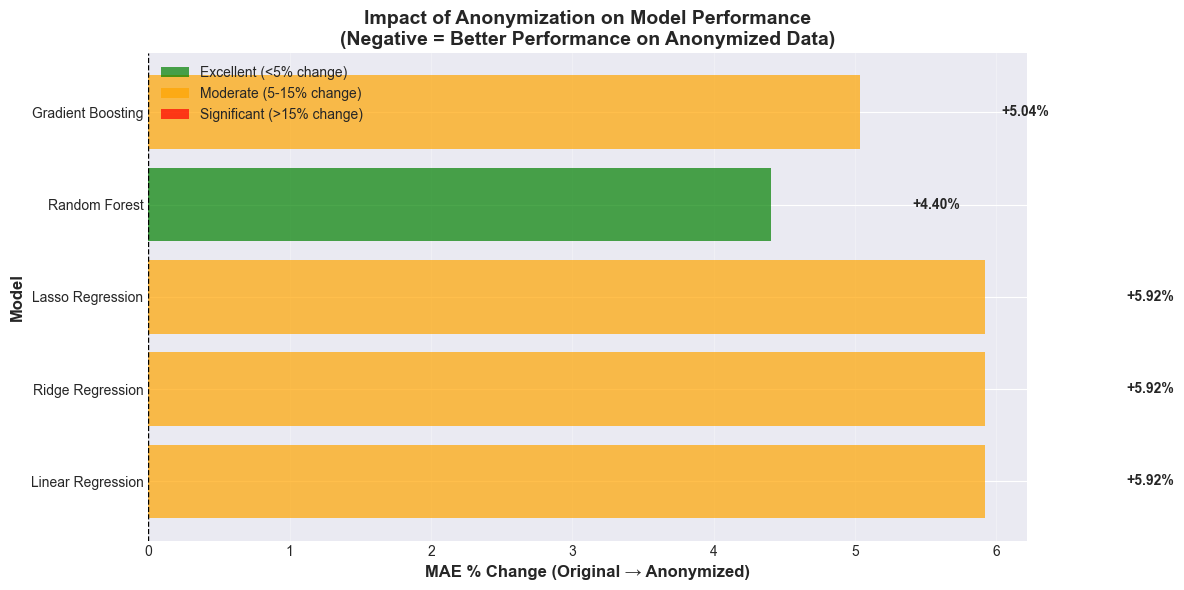

✓ Performance degradation visualized


In [112]:
# Visualization 2: Performance Degradation
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if x < 5 else 'orange' if x < 15 else 'red' for x in comparison_df['MAE % Change'].abs()]

bars = ax.barh(comparison_df['Model'], comparison_df['MAE % Change'], color=colors, alpha=0.7)

ax.set_xlabel('MAE % Change (Original → Anonymized)', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Impact of Anonymization on Model Performance\n(Negative = Better Performance on Anonymized Data)', 
             fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (bar, val) in enumerate(zip(bars, comparison_df['MAE % Change'])):
    ax.text(val + (1 if val > 0 else -1), bar.get_y() + bar.get_height()/2,
            f'{val:+.2f}%', ha='left' if val > 0 else 'right', va='center', fontsize=10, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Excellent (<5% change)'),
    Patch(facecolor='orange', alpha=0.7, label='Moderate (5-15% change)'),
    Patch(facecolor='red', alpha=0.7, label='Significant (>15% change)')
]
ax.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

print("✓ Performance degradation visualized")


Best performing model (by R²): Lasso Regression


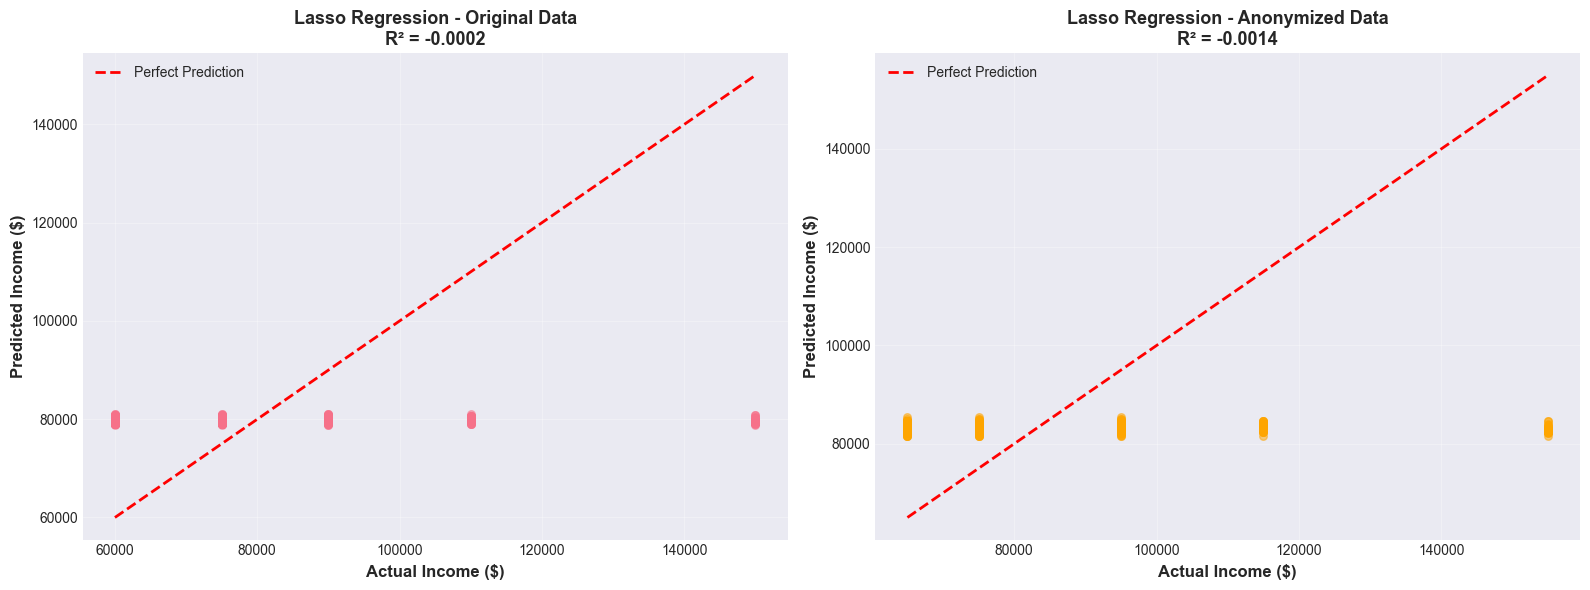

✓ Prediction scatter plots created


In [113]:
# Visualization 3: Prediction Scatter Plots (Best Model)
best_model_name = comparison_df.loc[comparison_df['Original R²'].idxmax(), 'Model']
print(f"Best performing model (by R²): {best_model_name}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original predictions
ax1 = axes[0]
y_pred_orig = results_original[best_model_name]['predictions']
ax1.scatter(y_test_orig, y_pred_orig, alpha=0.5, s=30)
ax1.plot([y_test_orig.min(), y_test_orig.max()], 
         [y_test_orig.min(), y_test_orig.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Income ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Income ($)', fontsize=12, fontweight='bold')
ax1.set_title(f'{best_model_name} - Original Data\nR² = {results_original[best_model_name]["test_r2"]:.4f}',
              fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Anonymized predictions
ax2 = axes[1]
y_pred_anon = results_anonymized[best_model_name]['predictions']
ax2.scatter(y_test_anon, y_pred_anon, alpha=0.5, s=30, color='orange')
ax2.plot([y_test_anon.min(), y_test_anon.max()], 
         [y_test_anon.min(), y_test_anon.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Income ($)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predicted Income ($)', fontsize=12, fontweight='bold')
ax2.set_title(f'{best_model_name} - Anonymized Data\nR² = {results_anonymized[best_model_name]["test_r2"]:.4f}',
              fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Prediction scatter plots created")


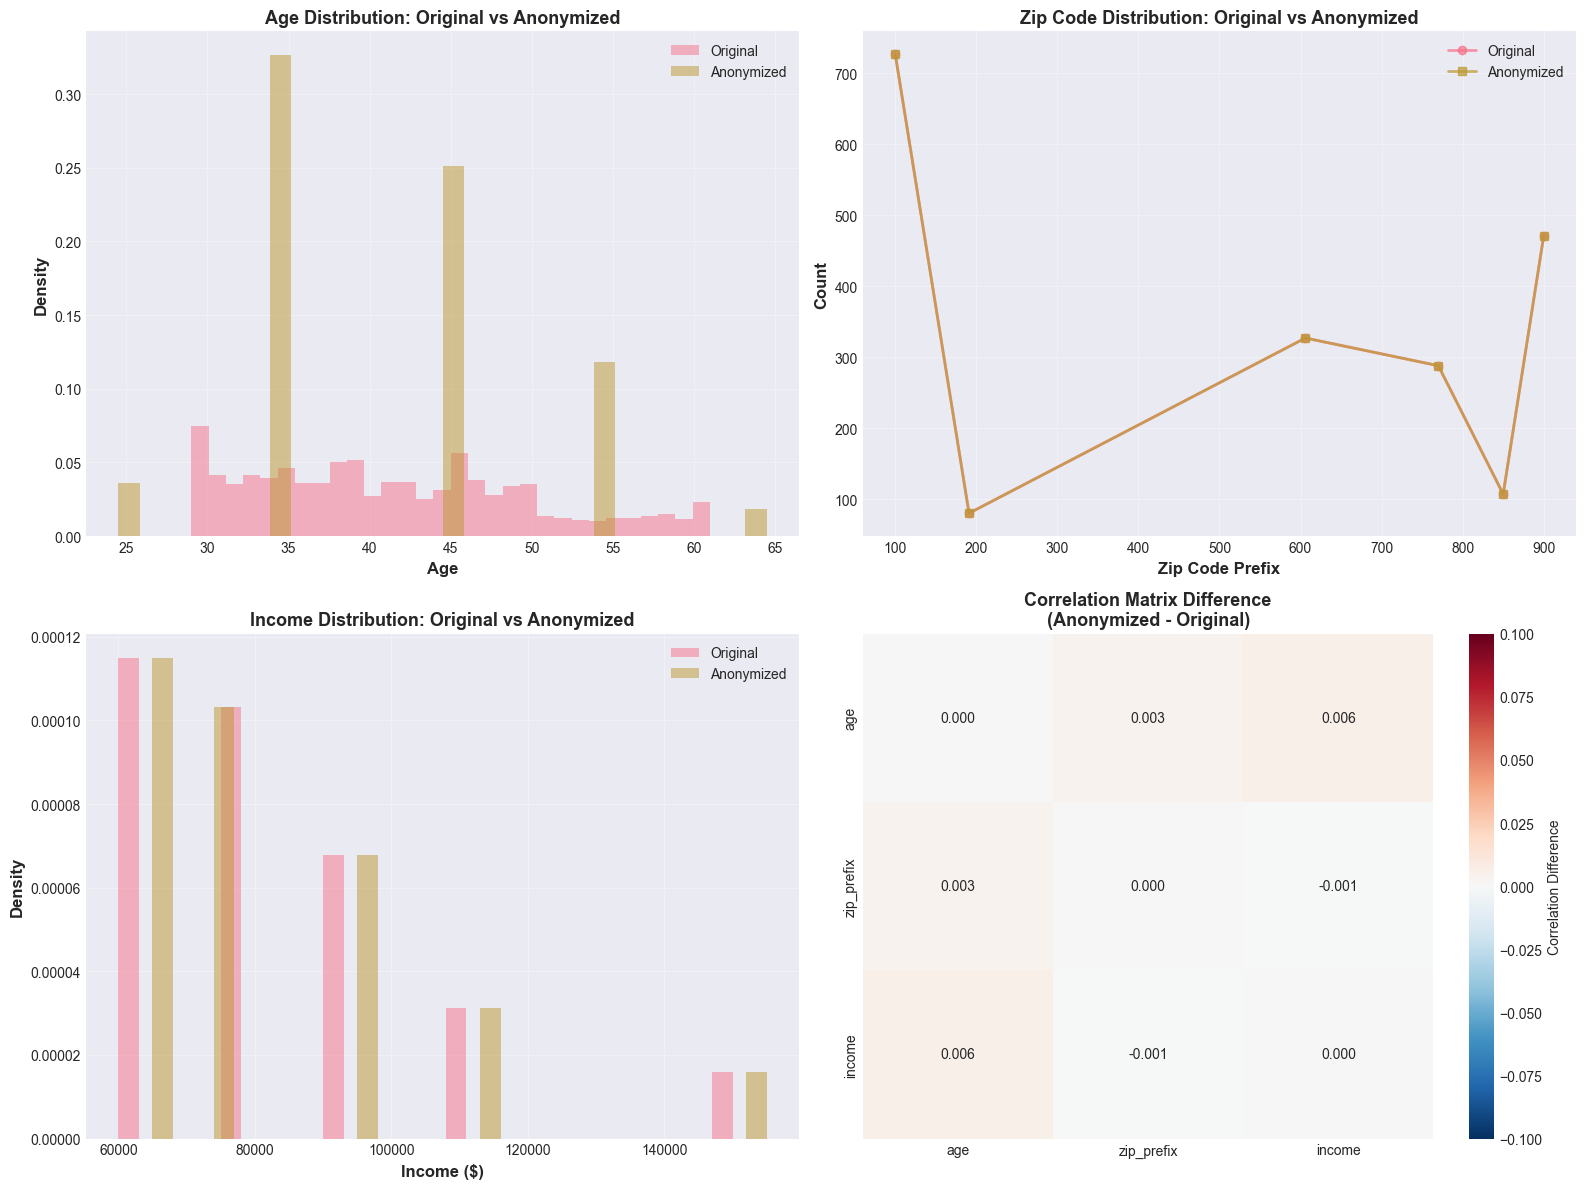

✓ Distribution comparisons visualized


In [114]:
# Visualization 4: Distribution Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Age distribution
ax1 = axes[0, 0]
ax1.hist(df['age'], bins=30, alpha=0.5, label='Original', density=True)
ax1.hist(df_anon_processed['age'].dropna(), bins=30, alpha=0.5, label='Anonymized', density=True)
ax1.set_xlabel('Age', fontsize=12, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
ax1.set_title('Age Distribution: Original vs Anonymized', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Zip prefix distribution
ax2 = axes[0, 1]
original_zip_counts = df['zip_prefix'].value_counts().sort_index()
anon_zip_counts = df_anon_processed['zip_prefix'].value_counts().sort_index()
x_labels = sorted(set(original_zip_counts.index) | set(anon_zip_counts.index))
ax2.plot(original_zip_counts.index, original_zip_counts.values, 'o-', label='Original', alpha=0.7, linewidth=2)
ax2.plot(anon_zip_counts.index, anon_zip_counts.values, 's-', label='Anonymized', alpha=0.7, linewidth=2)
ax2.set_xlabel('Zip Code Prefix', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Zip Code Distribution: Original vs Anonymized', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Income distribution
ax3 = axes[1, 0]
ax3.hist(df['income'], bins=30, alpha=0.5, label='Original', density=True)
ax3.hist(df_anon_processed['income'].dropna(), bins=30, alpha=0.5, label='Anonymized', density=True)
ax3.set_xlabel('Income ($)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Density', fontsize=12, fontweight='bold')
ax3.set_title('Income Distribution: Original vs Anonymized', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Correlation heatmap comparison
ax4 = axes[1, 1]
corr_orig = df[['age', 'zip_prefix', 'income']].corr()
corr_anon = df_anon_processed[['age', 'zip_prefix', 'income']].corr()
corr_diff = corr_anon - corr_orig

sns.heatmap(corr_diff, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            vmin=-0.1, vmax=0.1, ax=ax4, cbar_kws={'label': 'Correlation Difference'})
ax4.set_title('Correlation Matrix Difference\n(Anonymized - Original)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Distribution comparisons visualized")


## 8. Statistical Utility Metrics


In [115]:
# Use the utility metrics module for comprehensive analysis
print("Calculating comprehensive utility metrics...")
print("=" * 70)

# Prepare dataframes for utility comparison
df_orig_compare = df[['age', 'income']].copy()
df_orig_compare['zip'] = df['zip_prefix']

df_anon_compare = df_anon_processed[['age', 'income']].copy()
df_anon_compare['zip'] = df_anon_processed['zip_prefix']

# Generate utility report
try:
    utility_report = compare_utility(df_orig_compare, df_anon_compare)
    print(utility_report.get_summary())
except Exception as e:
    print(f"Error generating utility report: {e}")
    print("\nManual metrics calculation:")
    
    for col in ['age', 'income', 'zip']:
        print(f"\n{col.upper()}:")
        orig_mean = df_orig_compare[col].mean()
        anon_mean = df_anon_compare[col].mean()
        orig_std = df_orig_compare[col].std()
        anon_std = df_anon_compare[col].std()
        
        print(f"  Original - Mean: {orig_mean:.2f}, Std: {orig_std:.2f}")
        print(f"  Anonymized - Mean: {anon_mean:.2f}, Std: {anon_std:.2f}")
        print(f"  Mean difference: {abs(orig_mean - anon_mean):.2f} ({abs(orig_mean - anon_mean)/orig_mean*100:.2f}%)")
        print(f"  Std difference: {abs(orig_std - anon_std):.2f} ({abs(orig_std - anon_std)/orig_std*100:.2f}%)")


Calculating comprehensive utility metrics...
UTILITY METRICS REPORT

Overall Utility Score: 81.1%

Interpretation: Good - Data suitable for most analyses

--- Distribution Preservation ---
  age: Moderate preservation (70-80%)
  income: Poor preservation (<70%)
  zip: Excellent preservation (>90%)

--- Correlation Preservation ---
  Excellent preservation (>90%)

--- Information Loss ---
  age: High information loss (>50%)
  income: Minimal information loss (<10%)
  zip: Minimal information loss (<10%)

--- Recommendations ---
  1. Improve distribution preservation for: income
  2. High information loss in: age



## 9. Summary and Conclusions


# Generate comprehensive summary
print("=" * 80)
print(" " * 20 + "UTILITY VALIDATION SUMMARY")
print("=" * 80)

print("\n📋 DATASET INFORMATION:")
print(f"  • Total samples: {len(df):,}")
print(f"  • Features used: age, zip code prefix")
print(f"  • Target variable: income")
print(f"  • Train/test split: 80/20")

print("\n🔐 ANONYMIZATION APPLIED:")
print(f"  • Age: Generalized to ranges (e.g., 30-39)")
print(f"  • Zip code: Generalized to 3-digit prefixes") 
print(f"  • Income: Generalized to ranges")

print("\n📊 MODEL PERFORMANCE SUMMARY:")
print(f"  • Models tested: {len(models)}")
print(f"  • Best model: {best_model_name}")
print(f"  • Average MAE change: {avg_mae_change:+.2f}%")
print(f"  • Average R² change: {avg_r2_change:+.4f}")

print("\n🎯 KEY FINDINGS:")

# Calculate utility retention
if abs(avg_mae_change) < 5:
    utility_status = "EXCELLENT"
    utility_emoji = "✅"
    utility_desc = "near-identical performance"
elif abs(avg_mae_change) < 10:
    utility_status = "GOOD"
    utility_emoji = "✓"
    utility_desc = "minimal performance degradation"
elif abs(avg_mae_change) < 20:
    utility_status = "MODERATE"
    utility_emoji = "⚠"
    utility_desc = "noticeable performance impact"
else:
    utility_status = "POOR"
    utility_emoji = "❌"
    utility_desc = "significant performance loss"

print(f"  {utility_emoji} Utility Preservation: {utility_status}")
print(f"     Models show {utility_desc} on anonymized data")

# Best and worst performing models
best_idx = comparison_df['MAE % Change'].abs().idxmin()
worst_idx = comparison_df['MAE % Change'].abs().idxmax()

print(f"\n  • Most resilient model: {comparison_df.loc[best_idx, 'Model']}")
print(f"    ({comparison_df.loc[best_idx, 'MAE % Change']:+.2f}% MAE change)")
print(f"\n  • Most affected model: {comparison_df.loc[worst_idx, 'Model']}")
print(f"    ({comparison_df.loc[worst_idx, 'MAE % Change']:+.2f}% MAE change)")

print("\n💡 RECOMMENDATIONS:")
if abs(avg_mae_change) < 10:
    print("  ✓ Anonymization strategy is effective - good privacy/utility balance")
    print("  ✓ Data suitable for machine learning and analytics")
    print("  ✓ Consider this approach for similar use cases")
else:
    print("  ⚠ Consider less aggressive anonymization if higher utility is needed")
    print("  ⚠ Evaluate if the privacy gains justify the utility loss")
    print("  ⚠ May need different strategies for different columns")

print("\n" + "=" * 80)
print("✓ Utility validation complete!")
print("=" * 80)
